# IMO - Zadanie 6

Autorzy: Alex Terentowicz, Piotr Stawski
---

Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import time
import multiprocessing as mp
from copy import deepcopy
plt.rc('figure', dpi=110, figsize=(9, 5))

Reading instance functions:

In [2]:
def distance(a, b):
    return np.round(np.sqrt(np.sum((a - b)**2)))

def read_instance(path):
    coords = pd.read_csv(path, sep=' ', names=['n','x','y'], skiprows=6, skipfooter=1, engine='python')
    cities = coords.drop(columns=['n']).values
    ns = np.arange(len(cities))
    cities = np.array([[distance(cities[i], cities[j]) for j in ns] for i in ns])
    return cities, coords

Drawing functions:

In [3]:
def draw_path(coords, path, color='blue'):
    cycle = path + [path[0]]
    for i in range(len(cycle) - 1):
        a, b = cycle[i], cycle[i+1]
        plt.plot([coords.x[a], coords.x[b]], [coords.y[a], coords.y[b]], color=color)

def plot_solution(coords, solution):
    path1, path2 = solution
    draw_path(coords, path1, color='blue')
    draw_path(coords, path2, color='red')
    plt.scatter(coords.x, coords.y, color='grey')
    plt.show()

Scoring functions:

In [4]:
def cycle_score(cities, path):
    cycle = path + [path[0]]
    return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    return cycle_score(cities, paths[0]) + cycle_score(cities, paths[1])

def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]



Generating pairs of path indices for local search:

Replacing elements for local search (two cycles and one cycle):

In [5]:
# Score difference after replacing element "i" of path with chosen city
def delta_replace_vertex(cities, path, i, city):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    return cities[a, city] + cities[city, c] - cities[a, b] - cities[b, c]

# Score difference after exchanging 2 vertices of 2 different paths on indices i and j
def delta_replace_vertices_outside(cities, paths, i, j):
    return delta_replace_vertex(cities, paths[0], i, paths[1][j]) + delta_replace_vertex(cities, paths[1], j, paths[0][i])

# Score difference after exchanging 2 vertices of the same path on indices i and j
def delta_replace_vertices_inside(cities, path, i, j):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    d, e, f = path[(j-1)%path_len], path[j], path[(j+1)%path_len]
    if j-i == 1:
        return cities[a,e]+cities[b,f]-cities[a,b]-cities[e,f]
    elif (i, j) == (0, len(path)-1):
        return cities[e, c] + cities[d, b] - cities[b, c] - cities[d, e]
    else:
        return cities[a,e] + cities[e,c] + cities[d,b] + cities[b,f] -cities[a,b]-cities[b,c]-cities[d,e] - cities[e,f] 

# Score difference after exchanging 2 elements of the same path on edges between i and j
def delta_replace_edges_inside(cities, path, i, j):
    path_len = len(path)
    if (i, j) == (0, len(path)-1):
        a, b, c, d = path[i], path[(i+1)%path_len], path[(j-1)%path_len], path[j]
    else:
        a, b, c, d = path[(i - 1)%path_len], path[i], path[j], path[(j+1)%path_len]
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

# generates indices for testing every pair of two paths
def outside_candidates(paths):
    indices = list(range(len(paths[0]))), list(range(len(paths[1])))
    indices_pairwise = list(itertools.product(*indices))
    return indices_pairwise

# generates combinations of all pairs of one path
def inside_candidates(path):
    combinations = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            combinations.append([i, j])
    return combinations

def replace_vertices_outside(paths, i, j):
    temp = paths[0][i]
    paths[0][i] = paths[1][j]
    paths[1][j] = temp

def replace_vertices_inside(path, i, j):
    temp = path[i]
    path[i] = path[j]
    path[j] = temp
    
def replace_edges_inside(path, i, j):
    if (i, j) == (0, len(path)-1):
        temp = path[i]
        path[i] = path[j]
        path[j] = temp     
    path[i:j+1] = reversed(path[i:j+1])
    
class SteepestSearch(object):
    def __init__(self, cities, variant):
        self.variant = variant
        if variant == "vertices":
            self.delta = delta_replace_vertices_inside
            self.replace = replace_vertices_inside
        else:
            self.delta = delta_replace_edges_inside
            self.replace = replace_edges_inside
        self.cities = cities
        self.moves = [self.outside_vertices_trade_best, self.inside_trade_best]
    
    def outside_vertices_trade_best(self, cities, paths):
        candidates = outside_candidates(paths)
        scores = np.array([delta_replace_vertices_outside(cities, paths, i, j) for i, j in candidates])
        best_result_idx = np.argmin(scores)
        if scores[best_result_idx] < 0:
            return replace_vertices_outside, (paths, *candidates[best_result_idx]), scores[best_result_idx]
        return _, _, scores[best_result_idx]
            
    def inside_trade_best(self, cities, paths):
        combinations = inside_candidates(paths[0]), inside_candidates(paths[1])
        scores = np.array([[self.delta(cities, paths[idx], i, j) for i, j in combinations[idx]] for idx in range(len(paths))])
        best_path_idx, best_combination = np.unravel_index(np.argmin(scores), scores.shape)
        best_score = scores[best_path_idx, best_combination]
        if best_score < 0:
            return self.replace, (paths[best_path_idx], *combinations[best_path_idx][best_combination]), best_score
        return _, _, best_score 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        start = time.time()
        while True:
            replace_funs, args, scores = list(zip(*[move(self.cities, paths) for move in self.moves]))
            best_score_idx = np.argmin(scores)
            if scores[best_score_idx] < 0:
                replace_funs[best_score_idx](*args[best_score_idx])
            else:
                break
        return time.time()-start, paths

Initial solvers:

In [6]:
def solve_random(args):
    cities, _ = args
    n = cities.shape[0]
    remaining = list(range(n))
    random.seed()
    random.shuffle(remaining)
    paths = [remaining[:n//2], remaining[n//2:]]
    return paths

Greedy (first improvement) local search algorithm:

In [7]:
class GreedySearch(object):
    def __init__(self, cities, variant):
        self.variant = variant
        if variant == "vertices":
            self.delta = delta_replace_vertices_inside
            self.replace = replace_vertices_inside
        else:
            self.delta = delta_replace_edges_inside
            self.replace = replace_edges_inside
        self.cities = cities
        self.moves = [self.outside_vertices_trade_first, self.inside_trade_first]
    
    def outside_vertices_trade_first(self, cities, paths):
        random.seed()
        candidates = outside_candidates(paths)
        random.shuffle(candidates)
        for i, j in candidates:
            score_diff = delta_replace_vertices_outside(cities, paths, i, j)
            if score_diff < 0:
                replace_vertices_outside(paths, i, j)
                return score_diff
        return score_diff

    def inside_trade_first(self, cities, paths):
        random.seed()
        path_order = random.sample(range(2), 2)
        for idx in path_order:
            candidates = inside_candidates(paths[idx])
            random.shuffle(candidates)
            for i, j in candidates:
                score_diff = self.delta(cities, paths[idx], i, j)
                if score_diff < 0:
                    self.replace(paths[idx], i, j)
                    return score_diff
        return score_diff 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        random.seed()
        start = time.time()
        while True:
            move_order = random.sample(range(2), 2)
            score = self.moves[move_order[0]](self.cities, paths)
            if score >= 0: 
                score = self.moves[move_order[1]](self.cities, paths)
                if score >= 0: 
                    break
        return time.time()-start, paths

In [8]:
def check_edge(ver1, ver2, cycle):
    for i in range(0, len(cycle)-1):
        if cycle[i]==ver1:
            if cycle[i+1]==ver2:
#                 print(ver1, ver2, cycle)
                return 1
        if cycle[i]==ver2:
            if cycle[i+1]==ver1:
#                 print(ver2, ver1, cycle)
                return 1
    if cycle[-1]==ver1:
        if cycle[0]==ver2:
            return 1
    if cycle[-1]==ver2:
        if cycle[0]==ver1:
            return 1 
    return 0
    

def count_vertex(list1, list2):
    count = 0
    for i in range(0, len(list1)):
        for j in range(0, len(list2)):
            if list1[i] == list2[j]:
                count += 1
                break
    return count
  
    
def count_first_score(opt,best):
    sum1 = count_vertex(opt[0], best[0]) + count_vertex(opt[1], best[1])
    sum2 = count_vertex(opt[0], best[1]) + count_vertex(opt[1], best[0])
    return max(sum1,sum2)

def count_second_score(list1, list2):
    count = 0
    for i in range(len(list1[0]) - 1):
        count += check_edge(list1[0][i], list1[0][i+1], list2[0])
        count += check_edge(list1[0][i], list1[0][i+1], list2[1])
        count += check_edge(list2[0][i], list2[0][i+1], list2[0])
        count += check_edge(list2[0][i], list2[0][i+1], list2[1])

        
    count += check_edge(list1[0][-1], list1[0][0], list2[0])
    count += check_edge(list1[0][-1], list1[0][0], list2[1])
    count += check_edge(list1[1][-1], list1[1][0], list2[0])
    count += check_edge(list1[1][-1], list1[1][0], list2[1])
        
    return count
    


In [9]:
def show_results1000():
    instances = ['kroA200.tsp', 'kroB200.tsp']
    initial_solvers = [solve_random]
    score_results = []
    time_results = []
    best_score_arr = []
    first_scores_arr = []
    second_scores_arr = []
    avg_first_scores_arr = []
    avg_second_scores_arr = []
    all_solutions = []
    all_scores = []
    best_score = 100000000000000
    for file in instances:
        cities, coords = read_instance(file)
        local_variants = [GreedySearch(cities, "edges")]
        for solve in initial_solvers:
            times, new_solutions = [], []
            for i in range(1000):
                new_solutions = []
                for local_search in local_variants:
                    solution = solve((cities, i))
                    print(file, i)
                    time, new_solution = local_search(solution)
                    times.append(time)
                    new_solutions.append(new_solution)
                    all_solutions.append(new_solution)                   
                    new_scores = [score(cities, x) for x in new_solutions]
                    all_scores.append(new_scores[0])
                    for i in range(0, len(new_scores)):
                        if new_scores[i] < best_score:
                            best_score = new_scores[i]
                            best_idx = i
                            best = new_solutions[i]
    print("start measure")
    first_scores = []
    second_scores = []
    avg_first_scores = []
    avg_second_scores = []
    for i in range(len(all_solutions)):
        if(all_solutions[i]==best): 
            continue
        first_avg = 0
        second_avg = 0
#         print("COUNT AVG")
        for opt_for_avg in all_solutions:
            if(all_solutions[i]==opt_for_avg): continue
            first_avg += count_first_score(opt_for_avg,best)
            second_avg += count_second_score(opt_for_avg,best)
#             print(first_avg, second_avg)
#         print(first_avg, float(len(all_solutions)-1), first_avg/float(len(all_solutions)-1))
#         print(second_avg, float(len(all_solutions)-1), second_avg/float(len(all_solutions)-1))
        avg_first_scores_arr.append(first_avg/float(len(all_solutions)-1))
        avg_second_scores_arr.append(second_avg/float(len(all_solutions)-1))
        best_score_arr.append(all_scores[i])
        first_scores_arr.append(count_first_score(all_solutions[i],best))
        second_scores_arr.append(count_second_score(all_solutions[i],best))
#         avg_first_scores_arr.append(max(avg_first_scores))
#         avg_second_scores_arr.append(max(avg_second_scores))
                    
    return best_score, best_score_arr, first_scores_arr, second_scores_arr, avg_first_scores_arr, avg_second_scores_arr

In [10]:
best_score_arr = []
first_scores_arr = []
second_scores_arr = []
avg_first_scores_arr = []
avg_second_scores_arr = []
best_score, best_score_arr, first_scores_arr, second_scores_arr, avg_first_scores_arr, avg_second_scores_arr = show_results1000()
print(best_score)
# print(best_score_arr)
# print(first_scores_arr)
# print(second_scores_arr)
# print(avg_first_scores_arr)
# print(avg_second_scores_arr)

kroA200.tsp 0
kroA200.tsp 1
kroA200.tsp 2
kroA200.tsp 3
kroA200.tsp 4
kroA200.tsp 5
kroA200.tsp 6
kroA200.tsp 7
kroA200.tsp 8
kroA200.tsp 9
kroA200.tsp 10
kroA200.tsp 11
kroA200.tsp 12
kroA200.tsp 13
kroA200.tsp 14
kroA200.tsp 15
kroA200.tsp 16
kroA200.tsp 17
kroA200.tsp 18
kroA200.tsp 19
kroA200.tsp 20
kroA200.tsp 21
kroA200.tsp 22
kroA200.tsp 23
kroA200.tsp 24
kroA200.tsp 25
kroA200.tsp 26
kroA200.tsp 27
kroA200.tsp 28
kroA200.tsp 29
kroA200.tsp 30
kroA200.tsp 31
kroA200.tsp 32
kroA200.tsp 33
kroA200.tsp 34
kroA200.tsp 35
kroA200.tsp 36
kroA200.tsp 37
kroA200.tsp 38
kroA200.tsp 39
kroA200.tsp 40
kroA200.tsp 41
kroA200.tsp 42
kroA200.tsp 43
kroA200.tsp 44
kroA200.tsp 45
kroA200.tsp 46
kroA200.tsp 47
kroA200.tsp 48
kroA200.tsp 49
kroA200.tsp 50
kroA200.tsp 51
kroA200.tsp 52
kroA200.tsp 53
kroA200.tsp 54
kroA200.tsp 55
kroA200.tsp 56
kroA200.tsp 57
kroA200.tsp 58
kroA200.tsp 59
kroA200.tsp 60
kroA200.tsp 61
kroA200.tsp 62
kroA200.tsp 63
kroA200.tsp 64
kroA200.tsp 65
kroA200.tsp 66
kroA2

kroA200.tsp 519
kroA200.tsp 520
kroA200.tsp 521
kroA200.tsp 522
kroA200.tsp 523
kroA200.tsp 524
kroA200.tsp 525
kroA200.tsp 526
kroA200.tsp 527
kroA200.tsp 528
kroA200.tsp 529
kroA200.tsp 530
kroA200.tsp 531
kroA200.tsp 532
kroA200.tsp 533
kroA200.tsp 534
kroA200.tsp 535
kroA200.tsp 536
kroA200.tsp 537
kroA200.tsp 538
kroA200.tsp 539
kroA200.tsp 540
kroA200.tsp 541
kroA200.tsp 542
kroA200.tsp 543
kroA200.tsp 544
kroA200.tsp 545
kroA200.tsp 546
kroA200.tsp 547
kroA200.tsp 548
kroA200.tsp 549
kroA200.tsp 550
kroA200.tsp 551
kroA200.tsp 552
kroA200.tsp 553
kroA200.tsp 554
kroA200.tsp 555
kroA200.tsp 556
kroA200.tsp 557
kroA200.tsp 558
kroA200.tsp 559
kroA200.tsp 560
kroA200.tsp 561
kroA200.tsp 562
kroA200.tsp 563
kroA200.tsp 564
kroA200.tsp 565
kroA200.tsp 566
kroA200.tsp 567
kroA200.tsp 568
kroA200.tsp 569
kroA200.tsp 570
kroA200.tsp 571
kroA200.tsp 572
kroA200.tsp 573
kroA200.tsp 574
kroA200.tsp 575
kroA200.tsp 576
kroA200.tsp 577
kroA200.tsp 578
kroA200.tsp 579
kroA200.tsp 580
kroA200.

kroB200.tsp 34
kroB200.tsp 35
kroB200.tsp 36
kroB200.tsp 37
kroB200.tsp 38
kroB200.tsp 39
kroB200.tsp 40
kroB200.tsp 41
kroB200.tsp 42
kroB200.tsp 43
kroB200.tsp 44
kroB200.tsp 45
kroB200.tsp 46
kroB200.tsp 47
kroB200.tsp 48
kroB200.tsp 49
kroB200.tsp 50
kroB200.tsp 51
kroB200.tsp 52
kroB200.tsp 53
kroB200.tsp 54
kroB200.tsp 55
kroB200.tsp 56
kroB200.tsp 57
kroB200.tsp 58
kroB200.tsp 59
kroB200.tsp 60
kroB200.tsp 61
kroB200.tsp 62
kroB200.tsp 63
kroB200.tsp 64
kroB200.tsp 65
kroB200.tsp 66
kroB200.tsp 67
kroB200.tsp 68
kroB200.tsp 69
kroB200.tsp 70
kroB200.tsp 71
kroB200.tsp 72
kroB200.tsp 73
kroB200.tsp 74
kroB200.tsp 75
kroB200.tsp 76
kroB200.tsp 77
kroB200.tsp 78
kroB200.tsp 79
kroB200.tsp 80
kroB200.tsp 81
kroB200.tsp 82
kroB200.tsp 83
kroB200.tsp 84
kroB200.tsp 85
kroB200.tsp 86
kroB200.tsp 87
kroB200.tsp 88
kroB200.tsp 89
kroB200.tsp 90
kroB200.tsp 91
kroB200.tsp 92
kroB200.tsp 93
kroB200.tsp 94
kroB200.tsp 95
kroB200.tsp 96
kroB200.tsp 97
kroB200.tsp 98
kroB200.tsp 99
kroB200.ts

kroB200.tsp 551
kroB200.tsp 552
kroB200.tsp 553
kroB200.tsp 554
kroB200.tsp 555
kroB200.tsp 556
kroB200.tsp 557
kroB200.tsp 558
kroB200.tsp 559
kroB200.tsp 560
kroB200.tsp 561
kroB200.tsp 562
kroB200.tsp 563
kroB200.tsp 564
kroB200.tsp 565
kroB200.tsp 566
kroB200.tsp 567
kroB200.tsp 568
kroB200.tsp 569
kroB200.tsp 570
kroB200.tsp 571
kroB200.tsp 572
kroB200.tsp 573
kroB200.tsp 574
kroB200.tsp 575
kroB200.tsp 576
kroB200.tsp 577
kroB200.tsp 578
kroB200.tsp 579
kroB200.tsp 580
kroB200.tsp 581
kroB200.tsp 582
kroB200.tsp 583
kroB200.tsp 584
kroB200.tsp 585
kroB200.tsp 586
kroB200.tsp 587
kroB200.tsp 588
kroB200.tsp 589
kroB200.tsp 590
kroB200.tsp 591
kroB200.tsp 592
kroB200.tsp 593
kroB200.tsp 594
kroB200.tsp 595
kroB200.tsp 596
kroB200.tsp 597
kroB200.tsp 598
kroB200.tsp 599
kroB200.tsp 600
kroB200.tsp 601
kroB200.tsp 602
kroB200.tsp 603
kroB200.tsp 604
kroB200.tsp 605
kroB200.tsp 606
kroB200.tsp 607
kroB200.tsp 608
kroB200.tsp 609
kroB200.tsp 610
kroB200.tsp 611
kroB200.tsp 612
kroB200.

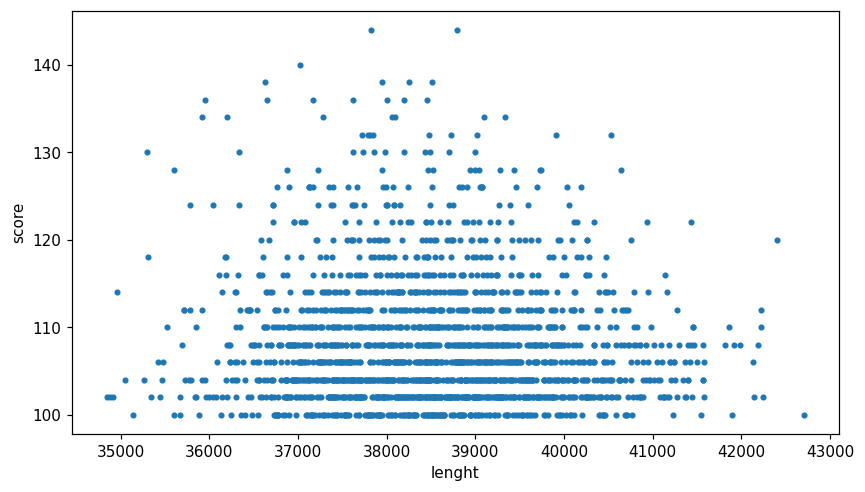

In [11]:
plt.plot(best_score_arr, first_scores_arr, ".")
plt.xlabel("lenght")
plt.ylabel("score")
plt.show()

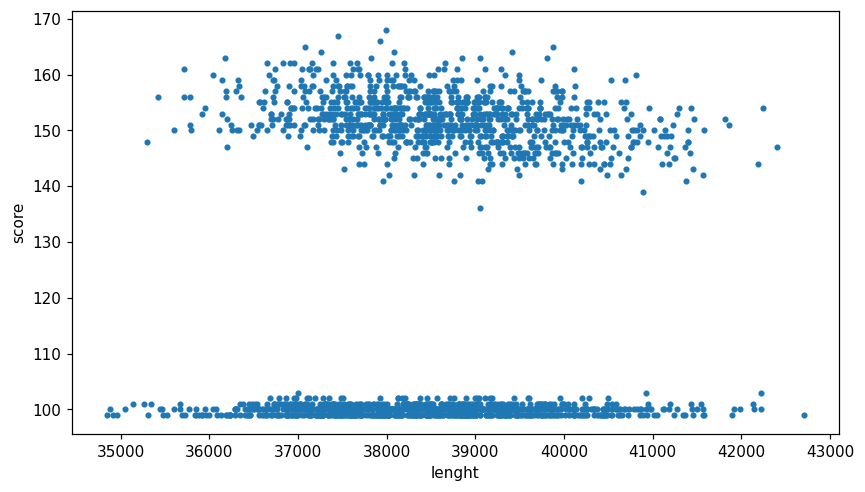

In [12]:
plt.plot(best_score_arr, second_scores_arr, ".")
plt.xlabel("lenght")
plt.ylabel("score")
plt.show()

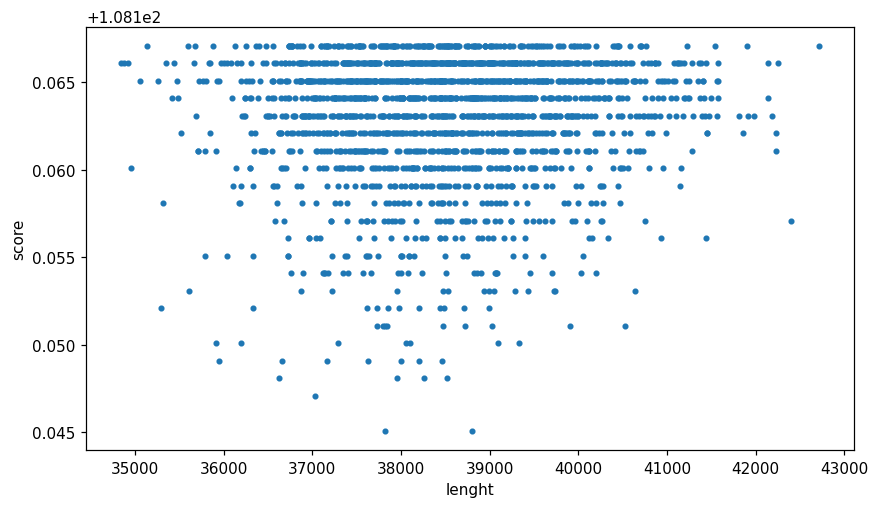

In [13]:
plt.plot(best_score_arr, avg_first_scores_arr, ".")
plt.xlabel("lenght")
plt.ylabel("score")
plt.show()

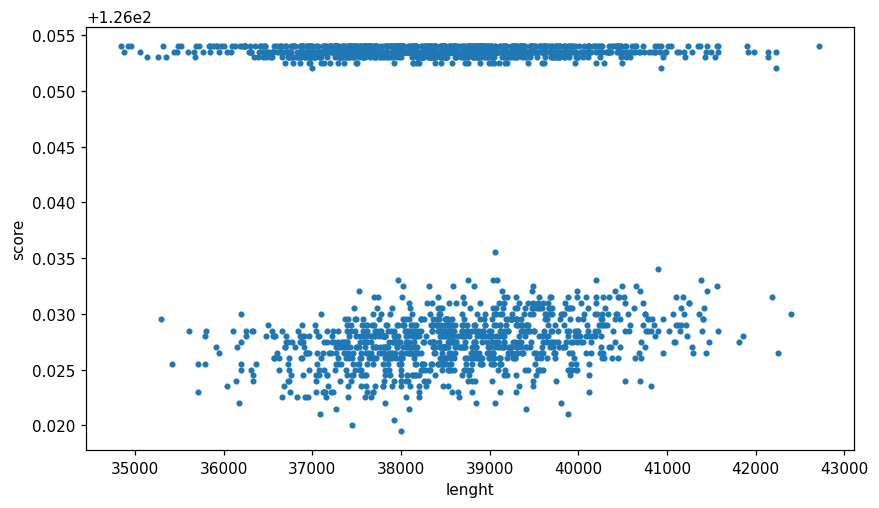

In [14]:
plt.plot(best_score_arr, avg_second_scores_arr, ".")
plt.xlabel("lenght")
plt.ylabel("score")
plt.show()

In [18]:
korelacja = np.corrcoef(best_score_arr, first_scores_arr)[0, 1]
print("Współczynnik korelacji Pearsona:", korelacja)
korelacja = np.corrcoef(best_score_arr, second_scores_arr)[0, 1]
print("Współczynnik korelacji Pearsona:", korelacja)
korelacja = np.corrcoef(best_score_arr, avg_first_scores_arr)[0, 1]
print("Współczynnik korelacji Pearsona:", korelacja)
korelacja = np.corrcoef(best_score_arr, avg_second_scores_arr)[0, 1]
print("Współczynnik korelacji Pearsona:", korelacja)

Współczynnik korelacji Pearsona: -0.06737664229668257
Współczynnik korelacji Pearsona: 0.06666488919458365
Współczynnik korelacji Pearsona: 0.06737664229672767
Współczynnik korelacji Pearsona: -0.0666648891945851
